# Configure SBS Process Params

This notebook should be used as a test for ensuring correct SBS image loading and processing before running SBS processing.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## Imports

In [1]:
import sys
from pathlib import Path

import yaml
from skimage.io import imread, imsave
import pandas as pd
from snakemake.io import expand
from microfilm import microplot
from microfilm.microplot import Micropanel


# TODO: Fix Brieflow package install to make this accessible without sys
lib_path = Path("../workflow/").resolve()
sys.path.append(str(lib_path))

from lib.shared.file_utils import get_filename
from lib.sbs_process.align_cycles import align_cycles
from lib.sbs_process.log_filter import log_filter
from lib.sbs_process.compute_standard_deviation import compute_standard_deviation
from lib.sbs_process.max_filter import max_filter
from lib.sbs_process.find_peaks import find_peaks

## SET PARAMETERS

### Parameters for testing SBS processing
- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing.
- `TEST_WELL`, `TEST_TILE`: Well/tile combination used for configuring parameters in this notebook.

In [2]:
CONFIG_FILE_PATH = "config/config.yml"
TEST_WELL = "A1"
TEST_TILE = 1

Loading test images...
Aligning test images...
Example aligned image for first cycle:


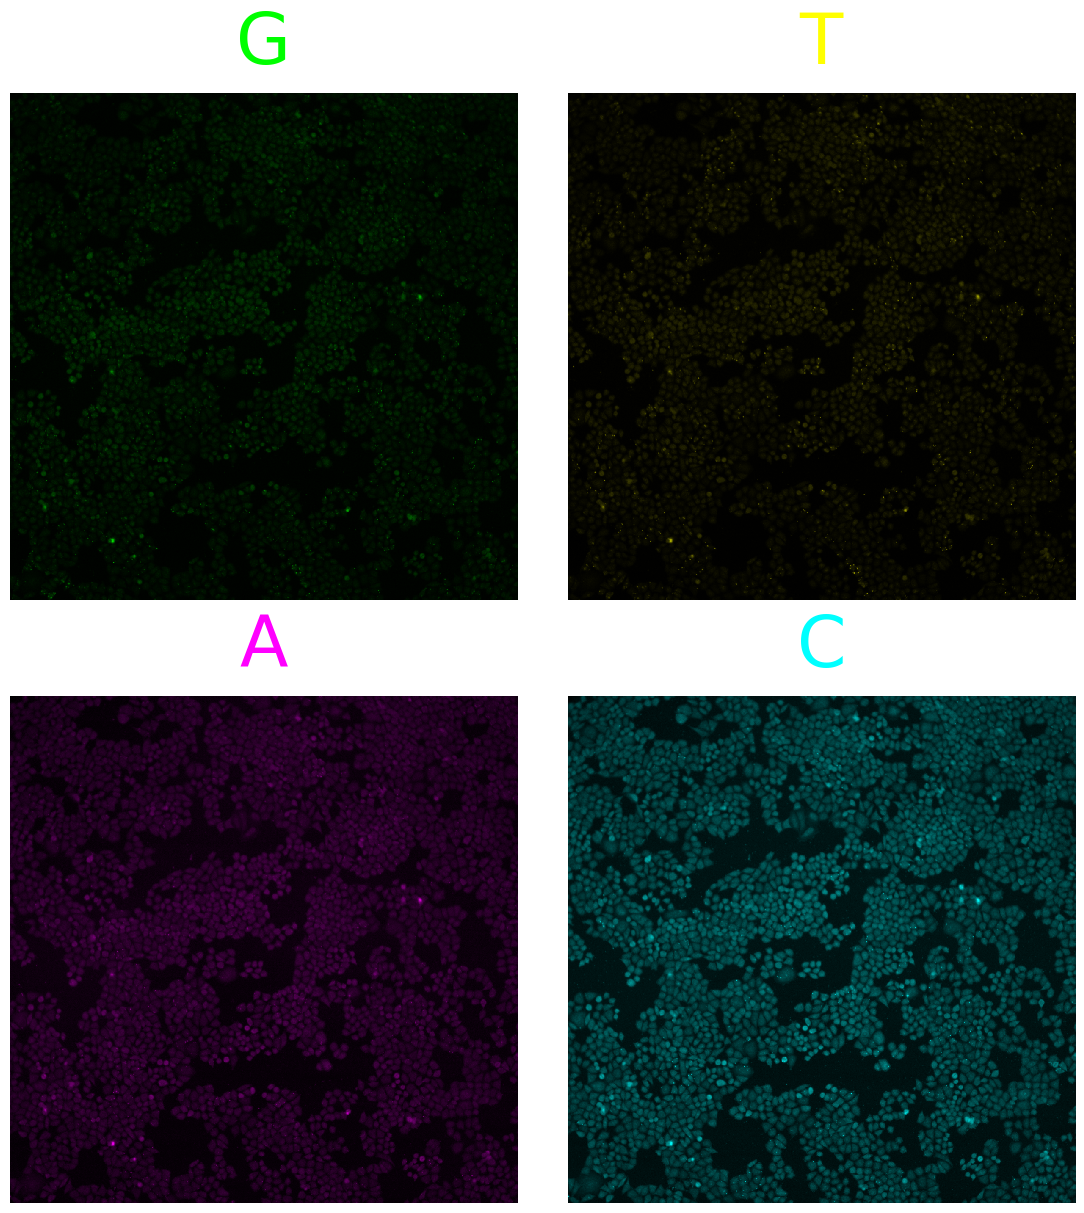

In [3]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# Get paths to the sample files dfs
SBS_SAMPLES_FP = Path(config["preprocess"]["sbs_samples_fp"])
# Load the sample TSV files with pandas
sbs_samples = pd.read_csv(SBS_SAMPLES_FP, sep="\t")
SBS_CYCLES = list(sbs_samples["cycle"].unique())

# load test image data
print("Loading test images...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / config["preprocess"]["suffix"]
sbs_test_image_paths = expand(
        PREPROCESS_FP
        / "images"
        / "sbs"
        / get_filename(
            {"well": TEST_WELL, "tile": TEST_TILE, "cycle": "{cycle}"},
            "image",
            "tiff",
        ),
        cycle=SBS_CYCLES,
    )
sbs_test_images = [imread(file_path) for file_path in sbs_test_image_paths]


# align cycles
print("Aligning test images...")
aligned = align_cycles(
    sbs_test_images,
    method="sbs_mean",
    upsample_factor=1,
)

print("Example aligned image for first cycle:")
# show aligned for one round
g_aligned_microshow = microplot.Microimage(
    aligned[0, 1, :, :], cmaps="pure_green", channel_names="G"
)
t_aligned_microshow = microplot.Microimage(
    aligned[0, 2, :, :], cmaps="pure_yellow", channel_names="T"
)
a_aligned_microshow = microplot.Microimage(
    aligned[0, 3, :, :], cmaps="pure_magenta", channel_names="A"
)
c_aligned_microshow = microplot.Microimage(
    aligned[0, 4, :, :], cmaps="pure_cyan", channel_names="C"
)
panel = Micropanel(rows=2, cols=2, figscaling=6)
panel.add_element([0, 0], g_aligned_microshow)
panel.add_element([0, 1], t_aligned_microshow)
panel.add_element([1, 0], a_aligned_microshow)
panel.add_element([1, 1], c_aligned_microshow)
panel.add_channel_label()

Detecting candidate reads...
Applying Laplacian-of-Gaussian (LoG) filter...
Computing standard deviation over cycles...
Applying max filter...
Finding peaks...
Example max filtered image for first cycle:


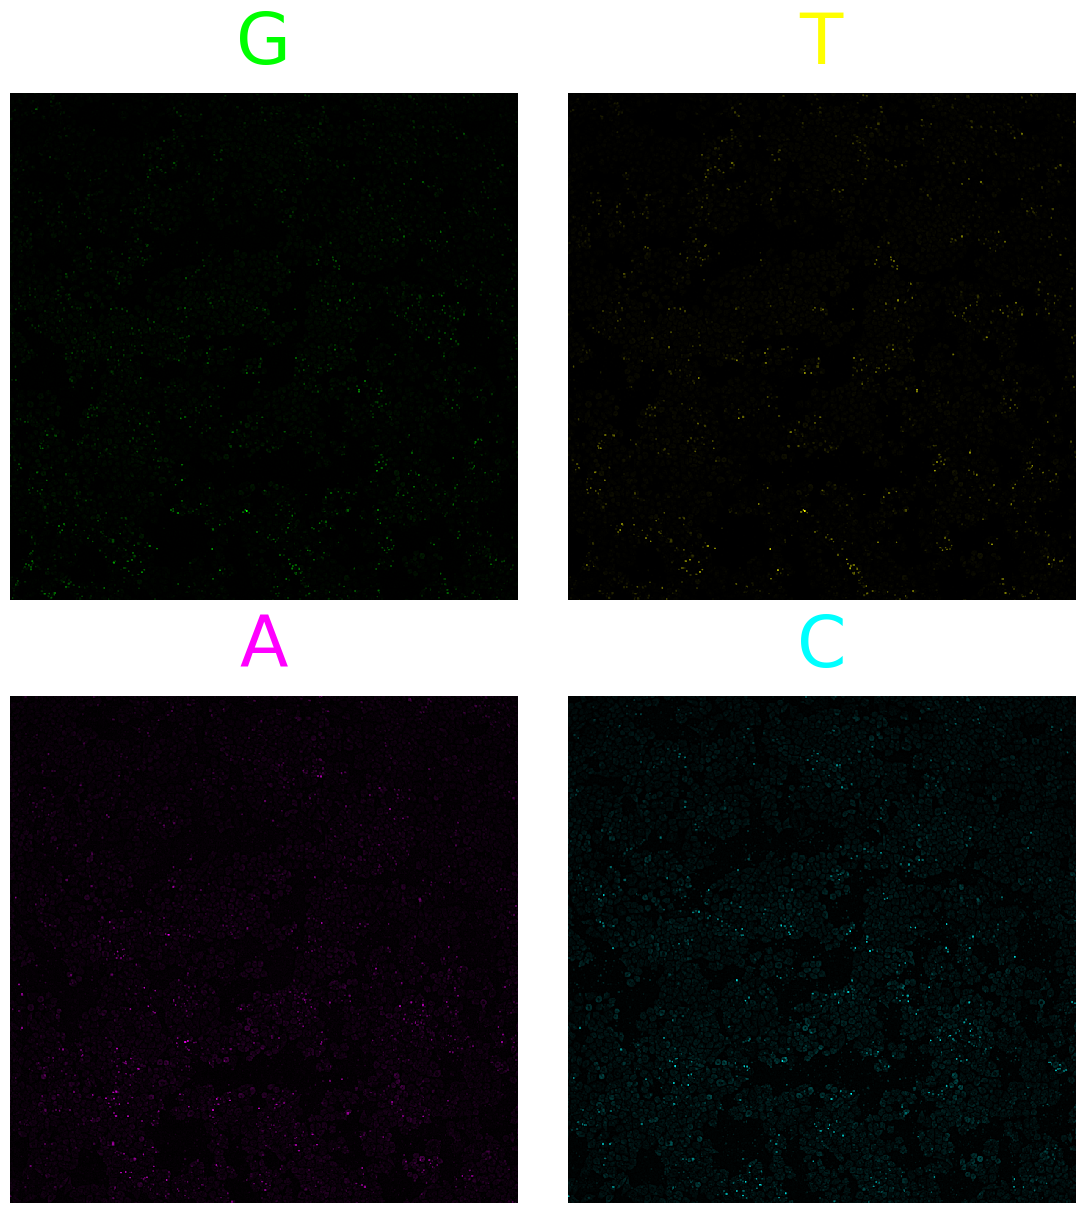

In [4]:
print("Detecting candidate reads...")

print("Applying Laplacian-of-Gaussian (LoG) filter...")
loged = log_filter(aligned, skip_index=0)

print("Computing standard deviation over cycles...")
standard_deviation = compute_standard_deviation(loged, remove_index=0)

print("Applying max filter...")
maxed = max_filter(loged, width=3, remove_index=0)

print("Finding peaks...")
peaks = find_peaks(standard_deviation)

print("Example max filtered image for first cycle:")
# show max filtered data for one round
g_maxed_microshow = microplot.Microimage(maxed[0, 0, :, :],
                                         cmaps='pure_green',
                                         channel_names='G')
t_maxed_microshow = microplot.Microimage(maxed[0, 1, :, :],
                                         cmaps='pure_yellow',
                                         channel_names='T')
a_maxed_microshow = microplot.Microimage(maxed[0, 2, :, :],
                                         cmaps='pure_magenta',
                                         channel_names='A')
c_maxed_microshow = microplot.Microimage(maxed[0, 3, :, :],
                                         cmaps='pure_cyan',
                                         channel_names='C')
panel = Micropanel(rows=2, cols=2, figscaling=6)
panel.add_element([0, 0], g_maxed_microshow)
panel.add_element([0, 1], t_maxed_microshow)
panel.add_element([1, 0], a_maxed_microshow)
panel.add_element([1, 1], c_maxed_microshow)
panel.add_channel_label()